# Composition of signatures within TTWA boundaries

In [20]:
import geopandas
import pandas
import tobler

# tobler.__version__

https://services1.arcgis.com/ESMARspQHYMw9BZ9/ArcGIS/rest/services/TTWA_2011_UK/FeatureServer

In [2]:
url = "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/TTWA_2011_UK/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryPolygon&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token="

In [3]:
ttwa = geopandas.read_file(url)

In [4]:
ttwa

,TTWA11CD,geometry
0,E30000004,"POLYGON ((-1.34865 53.58333, -1.32673 53.55813..."
1,E30000018,"POLYGON ((-1.93086 53.95027, -1.89833 53.92398..."
2,E30000029,"POLYGON ((-1.73679 53.70811, -1.73128 53.68037..."
3,E30000039,"POLYGON ((-2.00451 54.17288, -1.99254 54.15528..."
4,E30000046,"POLYGON ((-2.26489 50.75912, -2.24239 50.75563..."
...,...,...
223,W22000030,"MULTIPOLYGON (((-4.77992 52.76561, -4.80242 52..."
224,W22000031,"POLYGON ((-3.14509 53.26082, -3.17735 53.24382..."
225,W22000032,"POLYGON ((-3.47007 51.82850, -3.47633 51.80947..."
226,W22000033,"POLYGON ((-3.48307 52.86552, -3.50541 52.84191..."


In [5]:
# drop NI
ttwa = ttwa[~ttwa.TTWA11CD.str.startswith("N")]

<AxesSubplot:>

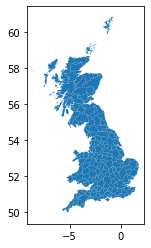

In [6]:
ttwa.plot()

In [30]:
ttwa.to_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa.pq")

<ipython-input-30-01f59cdfba9b>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  ttwa.to_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa.pq")


In [2]:
signatures = geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/signatures/signatures_combined_levels_simplified.pq")

In [3]:
types = {
    "0_0": "Countryside agriculture",
    "1_0": "Accessible suburbia",
    "3_0": "Open sprawl",
    "4_0": "Wild countryside",
    "5_0": "Warehouse land",
    "6_0": "Gridded residential quarters",
    "7_0": "Urban buffer",
    "8_0": "Disconnected suburbia",
    "2_0": "Dense residential neighbourhoods",
    "2_1": "Connected residential neighbourhoods",
    "2_2": "Dense urban neighbourhoods",
    "9_0": "Local urbanity",
    "9_1": "Distilled urbanity",
    "9_2": "Regional urbanity",
    "9_4": "Metropolitan urbanity",
    "9_5": "Hyper distilled urbanity",
}

signatures["signature_type"] = signatures["signature_type"].map(types)

In [4]:
signatures = signatures[["signature_type", "geometry"]].dropna()

In [10]:
signatures

,signature_type,geometry
0,Countryside agriculture,"POLYGON ((62219.999 798499.999, 62109.999 7985..."
1,Countryside agriculture,"POLYGON ((63507.682 796515.168, 63471.096 7965..."
2,Countryside agriculture,"POLYGON ((65953.174 802246.171, 65523.864 8023..."
3,Countryside agriculture,"POLYGON ((67297.740 803435.799, 67220.290 8034..."
4,Countryside agriculture,"POLYGON ((75760.000 852669.999, 75699.999 8527..."
...,...,...
96687,Hyper distilled urbanity,"POLYGON ((528602.733 181135.451, 528572.629 18..."
96688,Hyper distilled urbanity,"POLYGON ((528643.907 181217.443, 528632.000 18..."
96689,Hyper distilled urbanity,"POLYGON ((528734.583 181316.821, 528722.252 18..."
96690,Hyper distilled urbanity,"POLYGON ((530336.433 181039.754, 530301.430 18..."


In [11]:
%%time
interpolated = tobler.area_weighted.area_interpolate(signatures, ttwa.to_crs(signatures.crs), categorical_variables=["signature_type"], n_jobs=-1)

CPU times: user 5.54 s, sys: 336 ms, total: 5.88 s
Wall time: 56.1 s


In [13]:
interpolated.columns = [c[15:] for c in interpolated.columns]

In [15]:
interpolated["TTWA11CD"] = ttwa.TTWA11CD.values

In [16]:
interpolated

,Countryside agriculture,Accessible suburbia,Open sprawl,Wild countryside,Warehouse land,Gridded residential quarters,Urban buffer,Disconnected suburbia,Dense residential neighbourhoods,Connected residential neighbourhoods,Dense urban neighbourhoods,Local urbanity,Distilled urbanity,Regional urbanity,Metropolitan urbanity,Hyper distilled urbanity,,TTWA11CD
0,0.218571,0.043969,0.176920,0.079282,1.235609e-03,0.000215,0.467117,0.003725,0.006016,7.620440e-04,0.002179,0.000008,0.0,0.000000,0.00000,0.0,"POLYGON ((443219.518 409835.037, 444696.854 40...",E30000004
1,0.166363,0.045175,0.229543,0.030462,8.473206e-03,0.002243,0.431080,0.008993,0.032779,1.287391e-02,0.023451,0.008330,0.0,0.000230,0.00000,0.0,"POLYGON ((404635.122 450465.360, 406774.289 44...",E30000018
2,0.504775,0.008234,0.078947,0.115431,7.741750e-03,0.000413,0.254977,0.004334,0.018119,1.105400e-03,0.005319,0.000605,0.0,0.000000,0.00000,0.0,"POLYGON ((417471.523 423552.896, 417846.958 42...",E30000029
3,0.333012,0.000010,0.002617,0.626129,6.710558e-04,0.000000,0.036716,0.000069,0.000567,4.414055e-07,0.000182,0.000000,0.0,0.000000,0.00000,0.0,"POLYGON ((399803.434 475232.566, 400584.619 47...",E30000039
4,0.802061,0.003388,0.021588,0.029028,4.503935e-03,0.000505,0.122362,0.000286,0.004367,4.048234e-04,0.000823,0.000234,0.0,0.000074,0.00004,0.0,"POLYGON ((381412.611 95536.380, 382998.301 951...",E30000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0.293667,0.000214,0.000676,0.634816,1.737027e-05,0.000003,0.031056,0.000000,0.000197,1.286061e-05,0.000000,0.000000,0.0,0.000000,0.00000,0.0,"MULTIPOLYGON (((212541.096 322292.766, 210936....",W22000030
214,0.336676,0.009619,0.006018,0.554385,3.207763e-04,0.000965,0.089908,0.000154,0.000000,2.772906e-04,0.000000,0.000000,0.0,0.000000,0.00000,0.0,"POLYGON ((323712.675 374369.204, 321530.068 37...",W22000031
215,0.284508,0.017178,0.035579,0.107998,1.688731e-02,0.007048,0.512841,0.001141,0.003019,1.465991e-03,0.001280,0.000994,0.0,0.000110,0.00000,0.0,"POLYGON ((298789.856 215454.183, 298315.838 21...",W22000032
216,0.226124,0.000061,0.000709,0.750838,8.901256e-07,0.000000,0.016346,0.000098,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.00000,0.0,"POLYGON ((300258.629 330812.406, 298700.069 32...",W22000033


In [9]:
import pandas

names = pandas.read_csv("https://opendata.arcgis.com/api/v3/datasets/9ac894d3086641bebcbfa9960895db39_0/downloads/data?format=csv&spatialRefId=4326")

In [21]:
names

,TTWA11CD,TTWA11NM,FID
0,E30000004,Barnsley,1
1,S22000048,Alness and Invergordon,2
2,E30000018,Bradford,3
3,E30000029,Halifax,4
4,E30000039,Skipton,5
...,...,...,...
223,S22000013,Western Isles,224
224,S22000032,Mull and Islay,225
225,S22000035,Orkney Islands,226
226,S22000039,Shetland Islands,227


In [31]:
names.to_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa_names.pq")

In [22]:
interpolated = interpolated.merge(names[["TTWA11CD", "TTWA11NM"]], on="TTWA11CD", how="left")

In [23]:
interpolated

,Countryside agriculture,Accessible suburbia,Open sprawl,Wild countryside,Warehouse land,Gridded residential quarters,Urban buffer,Disconnected suburbia,Dense residential neighbourhoods,Connected residential neighbourhoods,Dense urban neighbourhoods,Local urbanity,Distilled urbanity,Regional urbanity,Metropolitan urbanity,Hyper distilled urbanity,,TTWA11CD,TTWA11NM
0,0.218571,0.043969,0.176920,0.079282,1.235609e-03,0.000215,0.467117,0.003725,0.006016,7.620440e-04,0.002179,0.000008,0.0,0.000000,0.00000,0.0,"POLYGON ((443219.518 409835.037, 444696.854 40...",E30000004,Barnsley
1,0.166363,0.045175,0.229543,0.030462,8.473206e-03,0.002243,0.431080,0.008993,0.032779,1.287391e-02,0.023451,0.008330,0.0,0.000230,0.00000,0.0,"POLYGON ((404635.122 450465.360, 406774.289 44...",E30000018,Bradford
2,0.504775,0.008234,0.078947,0.115431,7.741750e-03,0.000413,0.254977,0.004334,0.018119,1.105400e-03,0.005319,0.000605,0.0,0.000000,0.00000,0.0,"POLYGON ((417471.523 423552.896, 417846.958 42...",E30000029,Halifax
3,0.333012,0.000010,0.002617,0.626129,6.710558e-04,0.000000,0.036716,0.000069,0.000567,4.414055e-07,0.000182,0.000000,0.0,0.000000,0.00000,0.0,"POLYGON ((399803.434 475232.566, 400584.619 47...",E30000039,Skipton
4,0.802061,0.003388,0.021588,0.029028,4.503935e-03,0.000505,0.122362,0.000286,0.004367,4.048234e-04,0.000823,0.000234,0.0,0.000074,0.00004,0.0,"POLYGON ((381412.611 95536.380, 382998.301 951...",E30000046,Dorchester and Weymouth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0.293667,0.000214,0.000676,0.634816,1.737027e-05,0.000003,0.031056,0.000000,0.000197,1.286061e-05,0.000000,0.000000,0.0,0.000000,0.00000,0.0,"MULTIPOLYGON (((212541.096 322292.766, 210936....",W22000030,Pwllheli and Porthmadog
214,0.336676,0.009619,0.006018,0.554385,3.207763e-04,0.000965,0.089908,0.000154,0.000000,2.772906e-04,0.000000,0.000000,0.0,0.000000,0.00000,0.0,"POLYGON ((323712.675 374369.204, 321530.068 37...",W22000031,Rhyl
215,0.284508,0.017178,0.035579,0.107998,1.688731e-02,0.007048,0.512841,0.001141,0.003019,1.465991e-03,0.001280,0.000994,0.0,0.000110,0.00000,0.0,"POLYGON ((298789.856 215454.183, 298315.838 21...",W22000032,Swansea
216,0.226124,0.000061,0.000709,0.750838,8.901256e-07,0.000000,0.016346,0.000098,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.00000,0.0,"POLYGON ((300258.629 330812.406, 298700.069 32...",W22000033,Tywyn and Dolgellau


In [26]:
interpolated.columns = ['Countryside agriculture', 'Accessible suburbia', 'Open sprawl',
       'Wild countryside', 'Warehouse land', 'Gridded residential quarters',
       'Urban buffer', 'Disconnected suburbia',
       'Dense residential neighbourhoods',
       'Connected residential neighbourhoods', 'Dense urban neighbourhoods',
       'Local urbanity', 'Distilled urbanity', 'Regional urbanity',
       'Metropolitan urbanity', 'Hyper distilled urbanity', 'geometry', 'TTWA11CD',
       'TTWA11NM']

In [32]:
interpolated = geopandas.GeoDataFrame(interpolated, crs=27700)

In [29]:
interpolated.to_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa_interpolated.pq")

<ipython-input-29-0c6f61fce238>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  geopandas.GeoDataFrame(interpolated, crs=27700).to_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa_interpolated.pq")


In [5]:
interpolated = geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa_interpolated.pq")

In [33]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib.pyplot as plt
# import squarify
import urbangrammar_graphics as ugg

In [7]:
plot_data = interpolated.set_index("TTWA11NM").T.drop(["geometry", "TTWA11CD"])
plot_data

TTWA11NM,Barnsley,Bradford,Halifax,Skipton,Dorchester and Weymouth,Falmouth,Grantham,Hastings,Hexham,Isle of Wight,...,Cardiff,Cardigan,Colwyn Bay,Llanelli,Merthyr Tydfil,Pwllheli and Porthmadog,Rhyl,Swansea,Tywyn and Dolgellau,Wrexham
Countryside agriculture,0.218571,0.166363,0.504775,0.333012,0.802061,0.814348,0.895776,0.760641,0.094955,0.597957,...,0.195072,0.52362,0.247824,0.31493,0.354032,0.293667,0.336676,0.284508,0.226124,0.679714
Accessible suburbia,0.043969,0.045175,0.008234,0.00001,0.003388,0.001462,0.003265,0.029552,0.0,0.02578,...,0.026886,0.0,0.008341,0.000882,0.001534,0.000214,0.009619,0.017178,0.000061,0.008352
Open sprawl,0.17692,0.229543,0.078947,0.002617,0.021588,0.014442,0.008393,0.015345,0.000812,0.019786,...,0.104492,0.000554,0.006211,0.004573,0.043843,0.000676,0.006018,0.035579,0.000709,0.019098
Wild countryside,0.079282,0.030462,0.115431,0.626129,0.029028,0.026181,0.00005,0.000017,0.897122,0.000098,...,0.0,0.459751,0.668945,0.613634,0.201801,0.634816,0.554385,0.107998,0.750838,0.066124
Warehouse land,0.001236,0.008473,0.007742,0.000671,0.004504,0.000552,0.000426,0.000163,0.000008,0.000908,...,0.034154,0.000037,0.002057,0.000003,0.009063,0.000017,0.000321,0.016887,0.000001,0.003937
Gridded residential quarters,0.000215,0.002243,0.000413,0.0,0.000505,0.003124,0.000075,0.0,0.0,0.006856,...,0.018411,0.0,0.0008,0.001571,0.002301,0.000003,0.000965,0.007048,0.0,0.000004
Urban buffer,0.467117,0.43108,0.254977,0.036716,0.122362,0.094889,0.09007,0.165469,0.007009,0.325959,...,0.577927,0.007025,0.05864,0.059869,0.385135,0.031056,0.089908,0.512841,0.016346,0.216473
Disconnected suburbia,0.003725,0.008993,0.004334,0.000069,0.000286,0.002359,0.000676,0.003295,0.00001,0.000196,...,0.007809,0.000003,0.000006,0.000143,0.00054,0.0,0.000154,0.001141,0.000098,0.002296
Dense residential neighbourhoods,0.006016,0.032779,0.018119,0.000567,0.004367,0.000202,0.001139,0.005219,0.000085,0.003164,...,0.008218,0.0,0.000323,0.000008,0.000775,0.000197,0.0,0.003019,0.0,0.002831
Connected residential neighbourhoods,0.000762,0.012874,0.001105,0.0,0.000405,0.001662,0.000002,0.00368,0.0,0.000155,...,0.008751,0.0,0.002724,0.000003,0.000977,0.000013,0.000277,0.001466,0.0,0.000426


In [8]:
cmap = ugg.get_colormap(20, randomize=False)
cols = cmap.colors

symbology = {'0_0': cols[16],
             '1_0': cols[15],
             '3_0': cols[9],
             '4_0': cols[12],
             '5_0': cols[21],
             '6_0': cols[8],
             '7_0': cols[4],
             '8_0': cols[18],
             '2_0': cols[6],
             '2_1': cols[23],
             '2_2': cols[19],
             '9_0': cols[7],
             '9_1': cols[3],
             '9_2': cols[22],
             '9_4': cols[11],
             '9_5': cols[14],
            }
symbology = {types[k]:v for k, v in symbology.items()}

In [ ]:
for place in plot_data.columns:
    fig, ax = plt.subplots(figsize=(12, 12))
    squarify.plot(sizes=plot_data[place] + 0.00000001, pad=True, ax=ax, color=list(symbology.values()))
    ax.axis('off')
    plt.savefig(f"../../urbangrammar_samba/spatial_signatures/esda/ttwa_treemaps/{place}.pdf")
    plt.close()

<AxesSubplot:xlabel='TTWA11NM'>

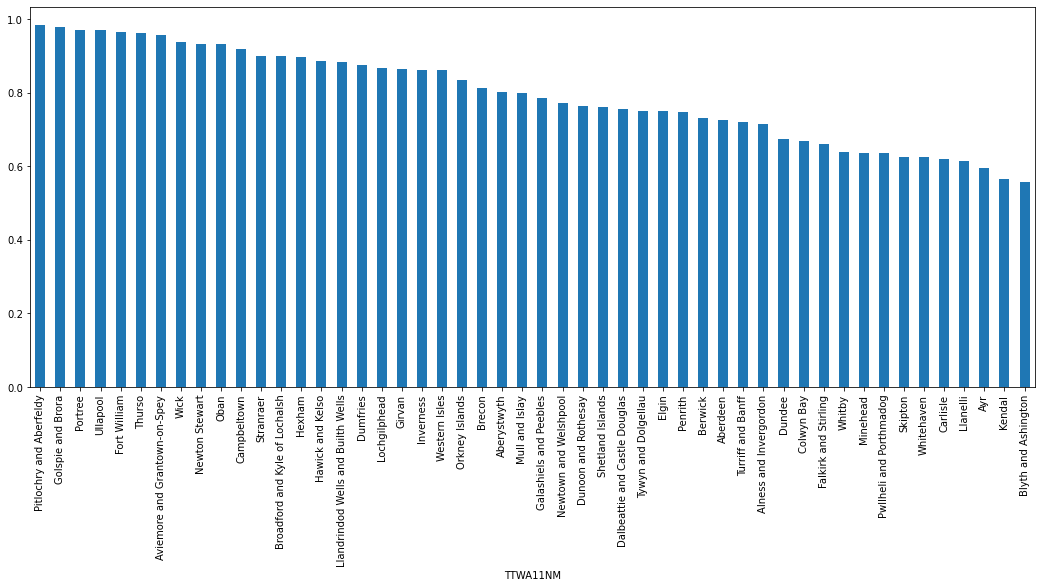

In [9]:
plot_data.T["Wild countryside"].sort_values(ascending=False).iloc[:50].plot.bar(figsize=(18, 7))

In [103]:
for sig in plot_data.index:
    
    ax = interpolated.plot(sig, figsize=(15, 15), legend=True)
    ax.axis('off')
    plt.savefig(f"../../urbangrammar_samba/spatial_signatures/esda/ttwa_maps/{sig}.png")
    plt.close()

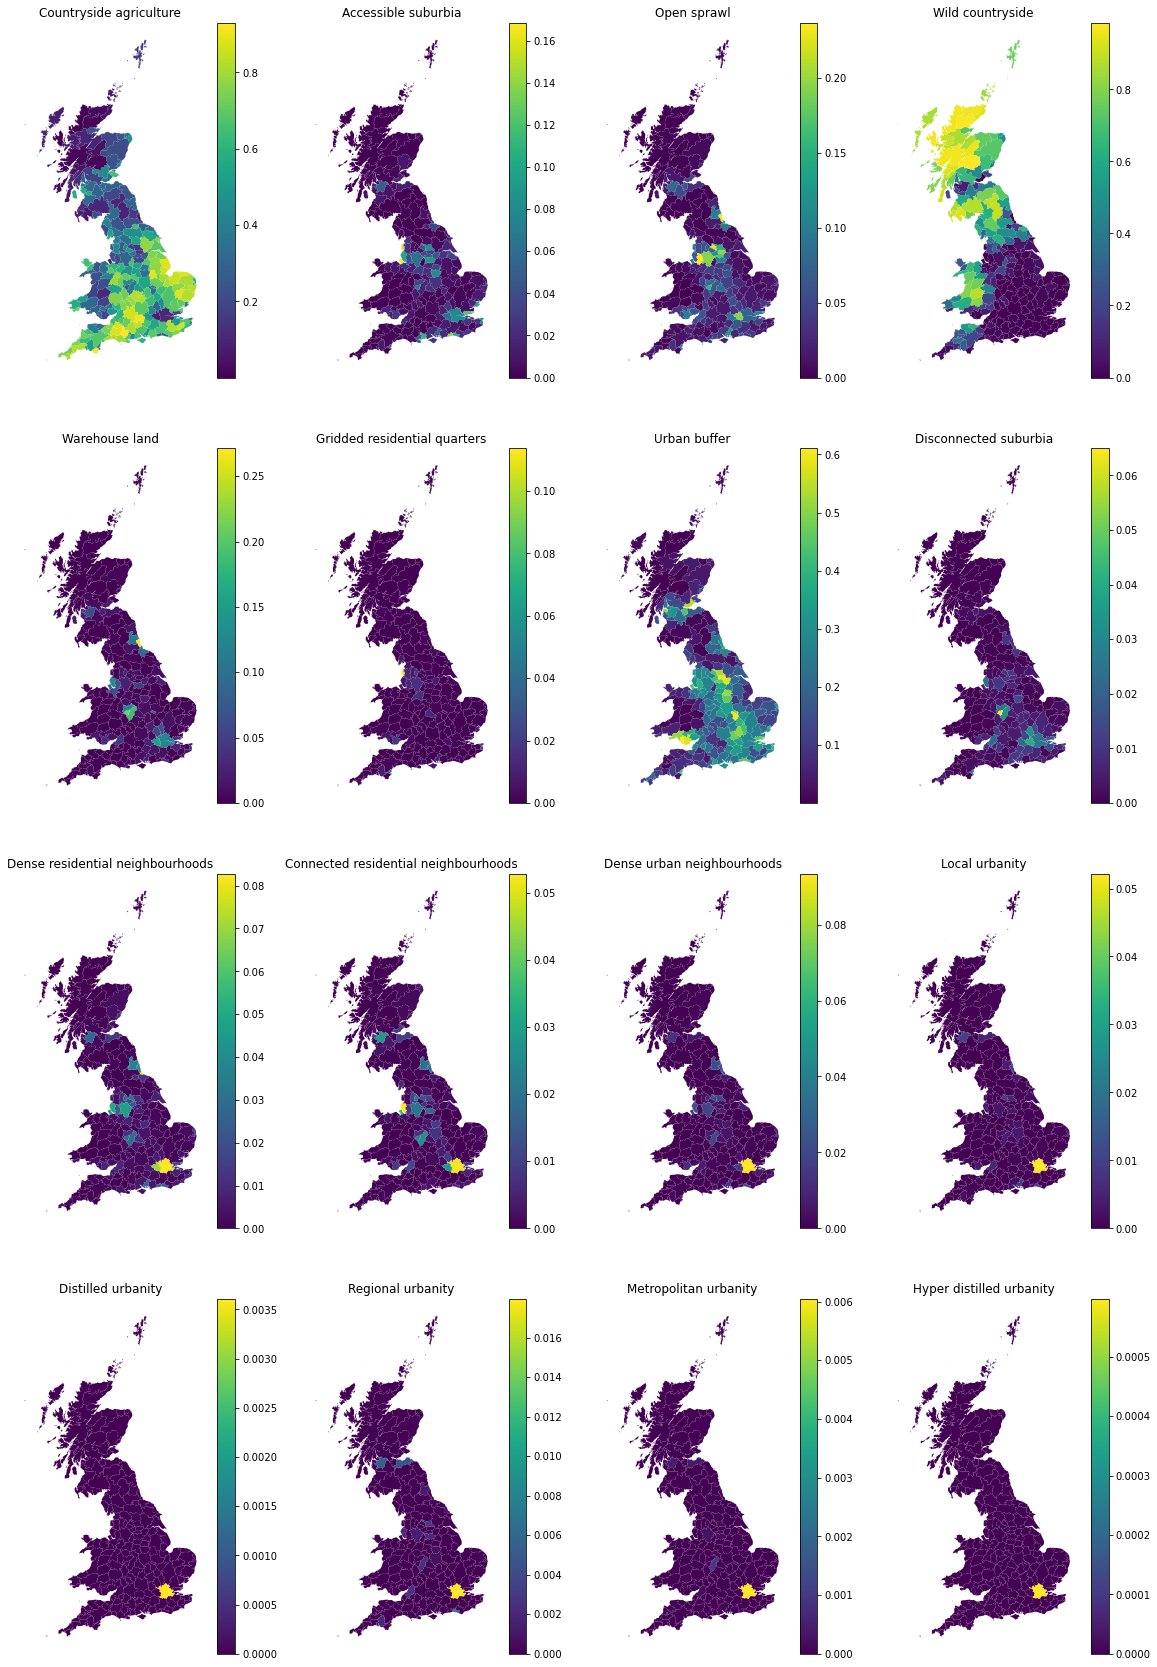

In [10]:
fig, axs = plt.subplots(4, 4, figsize=(20, 30))
axs = axs.flatten()
for i, sig in enumerate(plot_data.index):
    interpolated.plot(sig, ax=axs[i], legend=True)
    axs[i].axis("off")
    axs[i].set_title(sig)

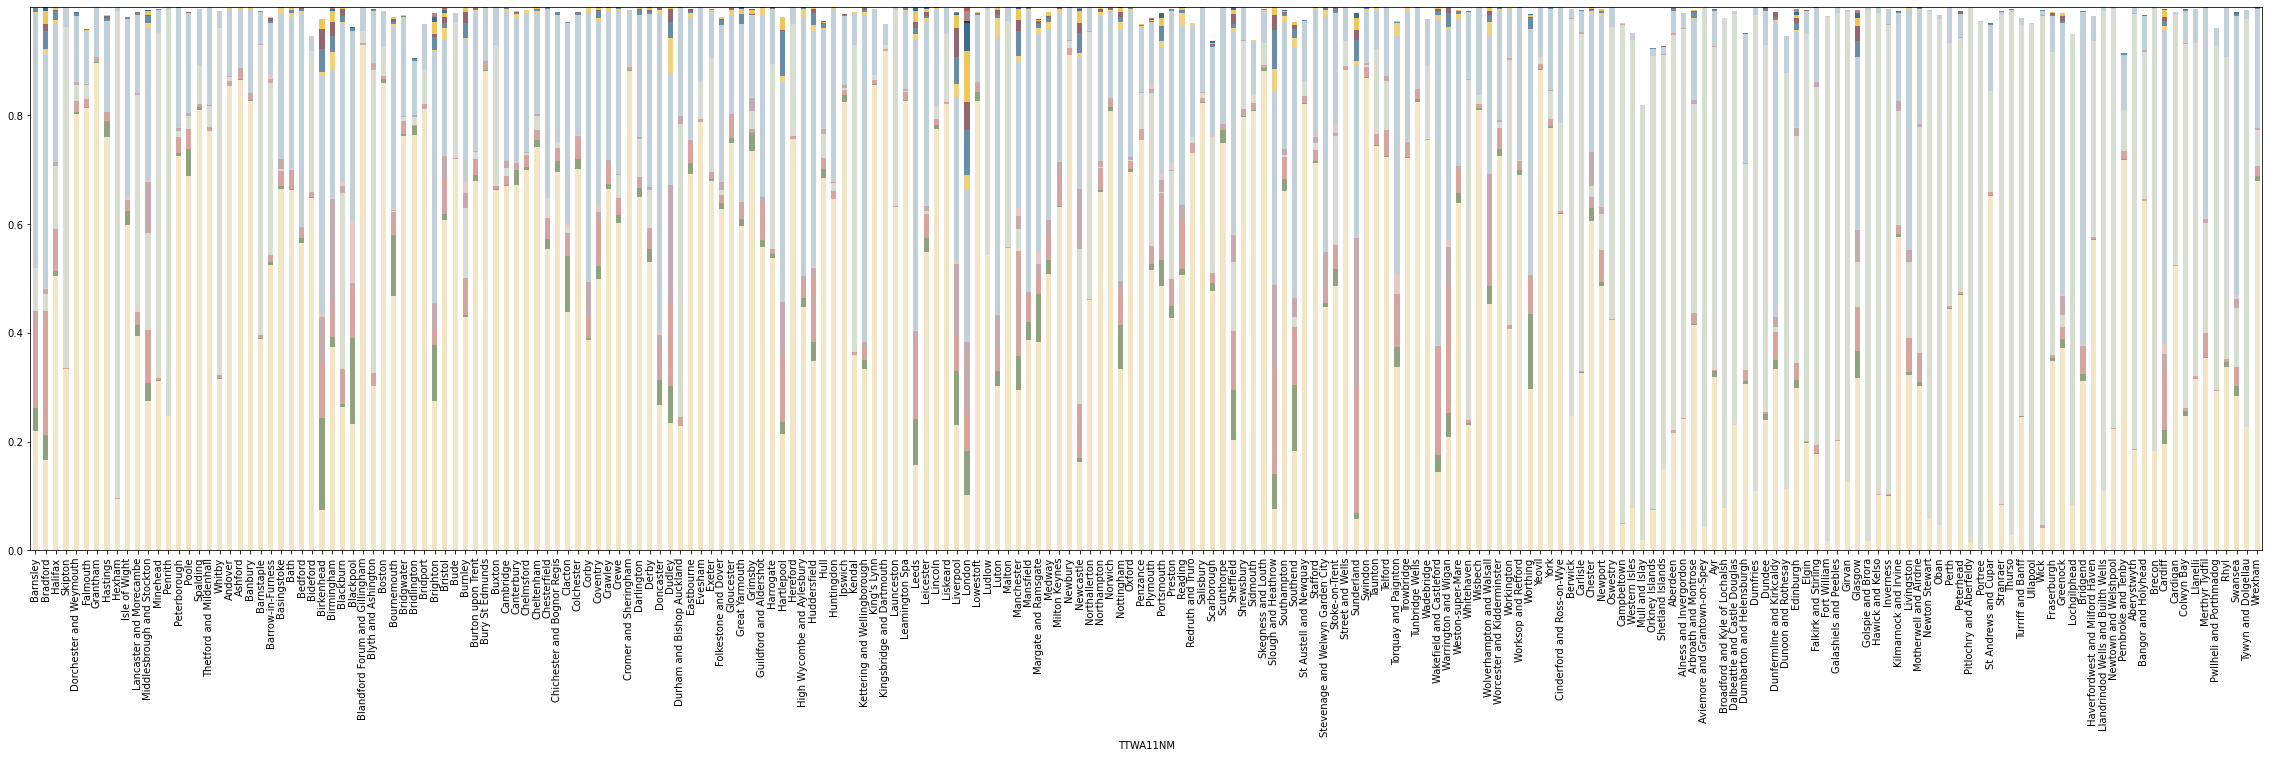

In [124]:
ax = plot_data.T.plot.bar(color=list(symbology.values()), stacked=True, figsize=(40, 10), legend=False)

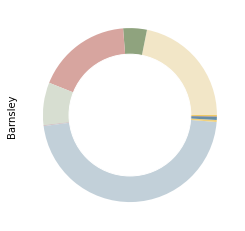

In [11]:
ax = plot_data["Barnsley"].plot.pie(colors=list(symbology.values()), labels=None, normalize=True)
ax.add_artist(plt.Circle((0,0), .7, color="w"))

In [12]:
plot_data

TTWA11NM,Barnsley,Bradford,Halifax,Skipton,Dorchester and Weymouth,Falmouth,Grantham,Hastings,Hexham,Isle of Wight,...,Cardiff,Cardigan,Colwyn Bay,Llanelli,Merthyr Tydfil,Pwllheli and Porthmadog,Rhyl,Swansea,Tywyn and Dolgellau,Wrexham
Countryside agriculture,0.218571,0.166363,0.504775,0.333012,0.802061,0.814348,0.895776,0.760641,0.094955,0.597957,...,0.195072,0.52362,0.247824,0.31493,0.354032,0.293667,0.336676,0.284508,0.226124,0.679714
Accessible suburbia,0.043969,0.045175,0.008234,0.00001,0.003388,0.001462,0.003265,0.029552,0.0,0.02578,...,0.026886,0.0,0.008341,0.000882,0.001534,0.000214,0.009619,0.017178,0.000061,0.008352
Open sprawl,0.17692,0.229543,0.078947,0.002617,0.021588,0.014442,0.008393,0.015345,0.000812,0.019786,...,0.104492,0.000554,0.006211,0.004573,0.043843,0.000676,0.006018,0.035579,0.000709,0.019098
Wild countryside,0.079282,0.030462,0.115431,0.626129,0.029028,0.026181,0.00005,0.000017,0.897122,0.000098,...,0.0,0.459751,0.668945,0.613634,0.201801,0.634816,0.554385,0.107998,0.750838,0.066124
Warehouse land,0.001236,0.008473,0.007742,0.000671,0.004504,0.000552,0.000426,0.000163,0.000008,0.000908,...,0.034154,0.000037,0.002057,0.000003,0.009063,0.000017,0.000321,0.016887,0.000001,0.003937
Gridded residential quarters,0.000215,0.002243,0.000413,0.0,0.000505,0.003124,0.000075,0.0,0.0,0.006856,...,0.018411,0.0,0.0008,0.001571,0.002301,0.000003,0.000965,0.007048,0.0,0.000004
Urban buffer,0.467117,0.43108,0.254977,0.036716,0.122362,0.094889,0.09007,0.165469,0.007009,0.325959,...,0.577927,0.007025,0.05864,0.059869,0.385135,0.031056,0.089908,0.512841,0.016346,0.216473
Disconnected suburbia,0.003725,0.008993,0.004334,0.000069,0.000286,0.002359,0.000676,0.003295,0.00001,0.000196,...,0.007809,0.000003,0.000006,0.000143,0.00054,0.0,0.000154,0.001141,0.000098,0.002296
Dense residential neighbourhoods,0.006016,0.032779,0.018119,0.000567,0.004367,0.000202,0.001139,0.005219,0.000085,0.003164,...,0.008218,0.0,0.000323,0.000008,0.000775,0.000197,0.0,0.003019,0.0,0.002831
Connected residential neighbourhoods,0.000762,0.012874,0.001105,0.0,0.000405,0.001662,0.000002,0.00368,0.0,0.000155,...,0.008751,0.0,0.002724,0.000003,0.000977,0.000013,0.000277,0.001466,0.0,0.000426


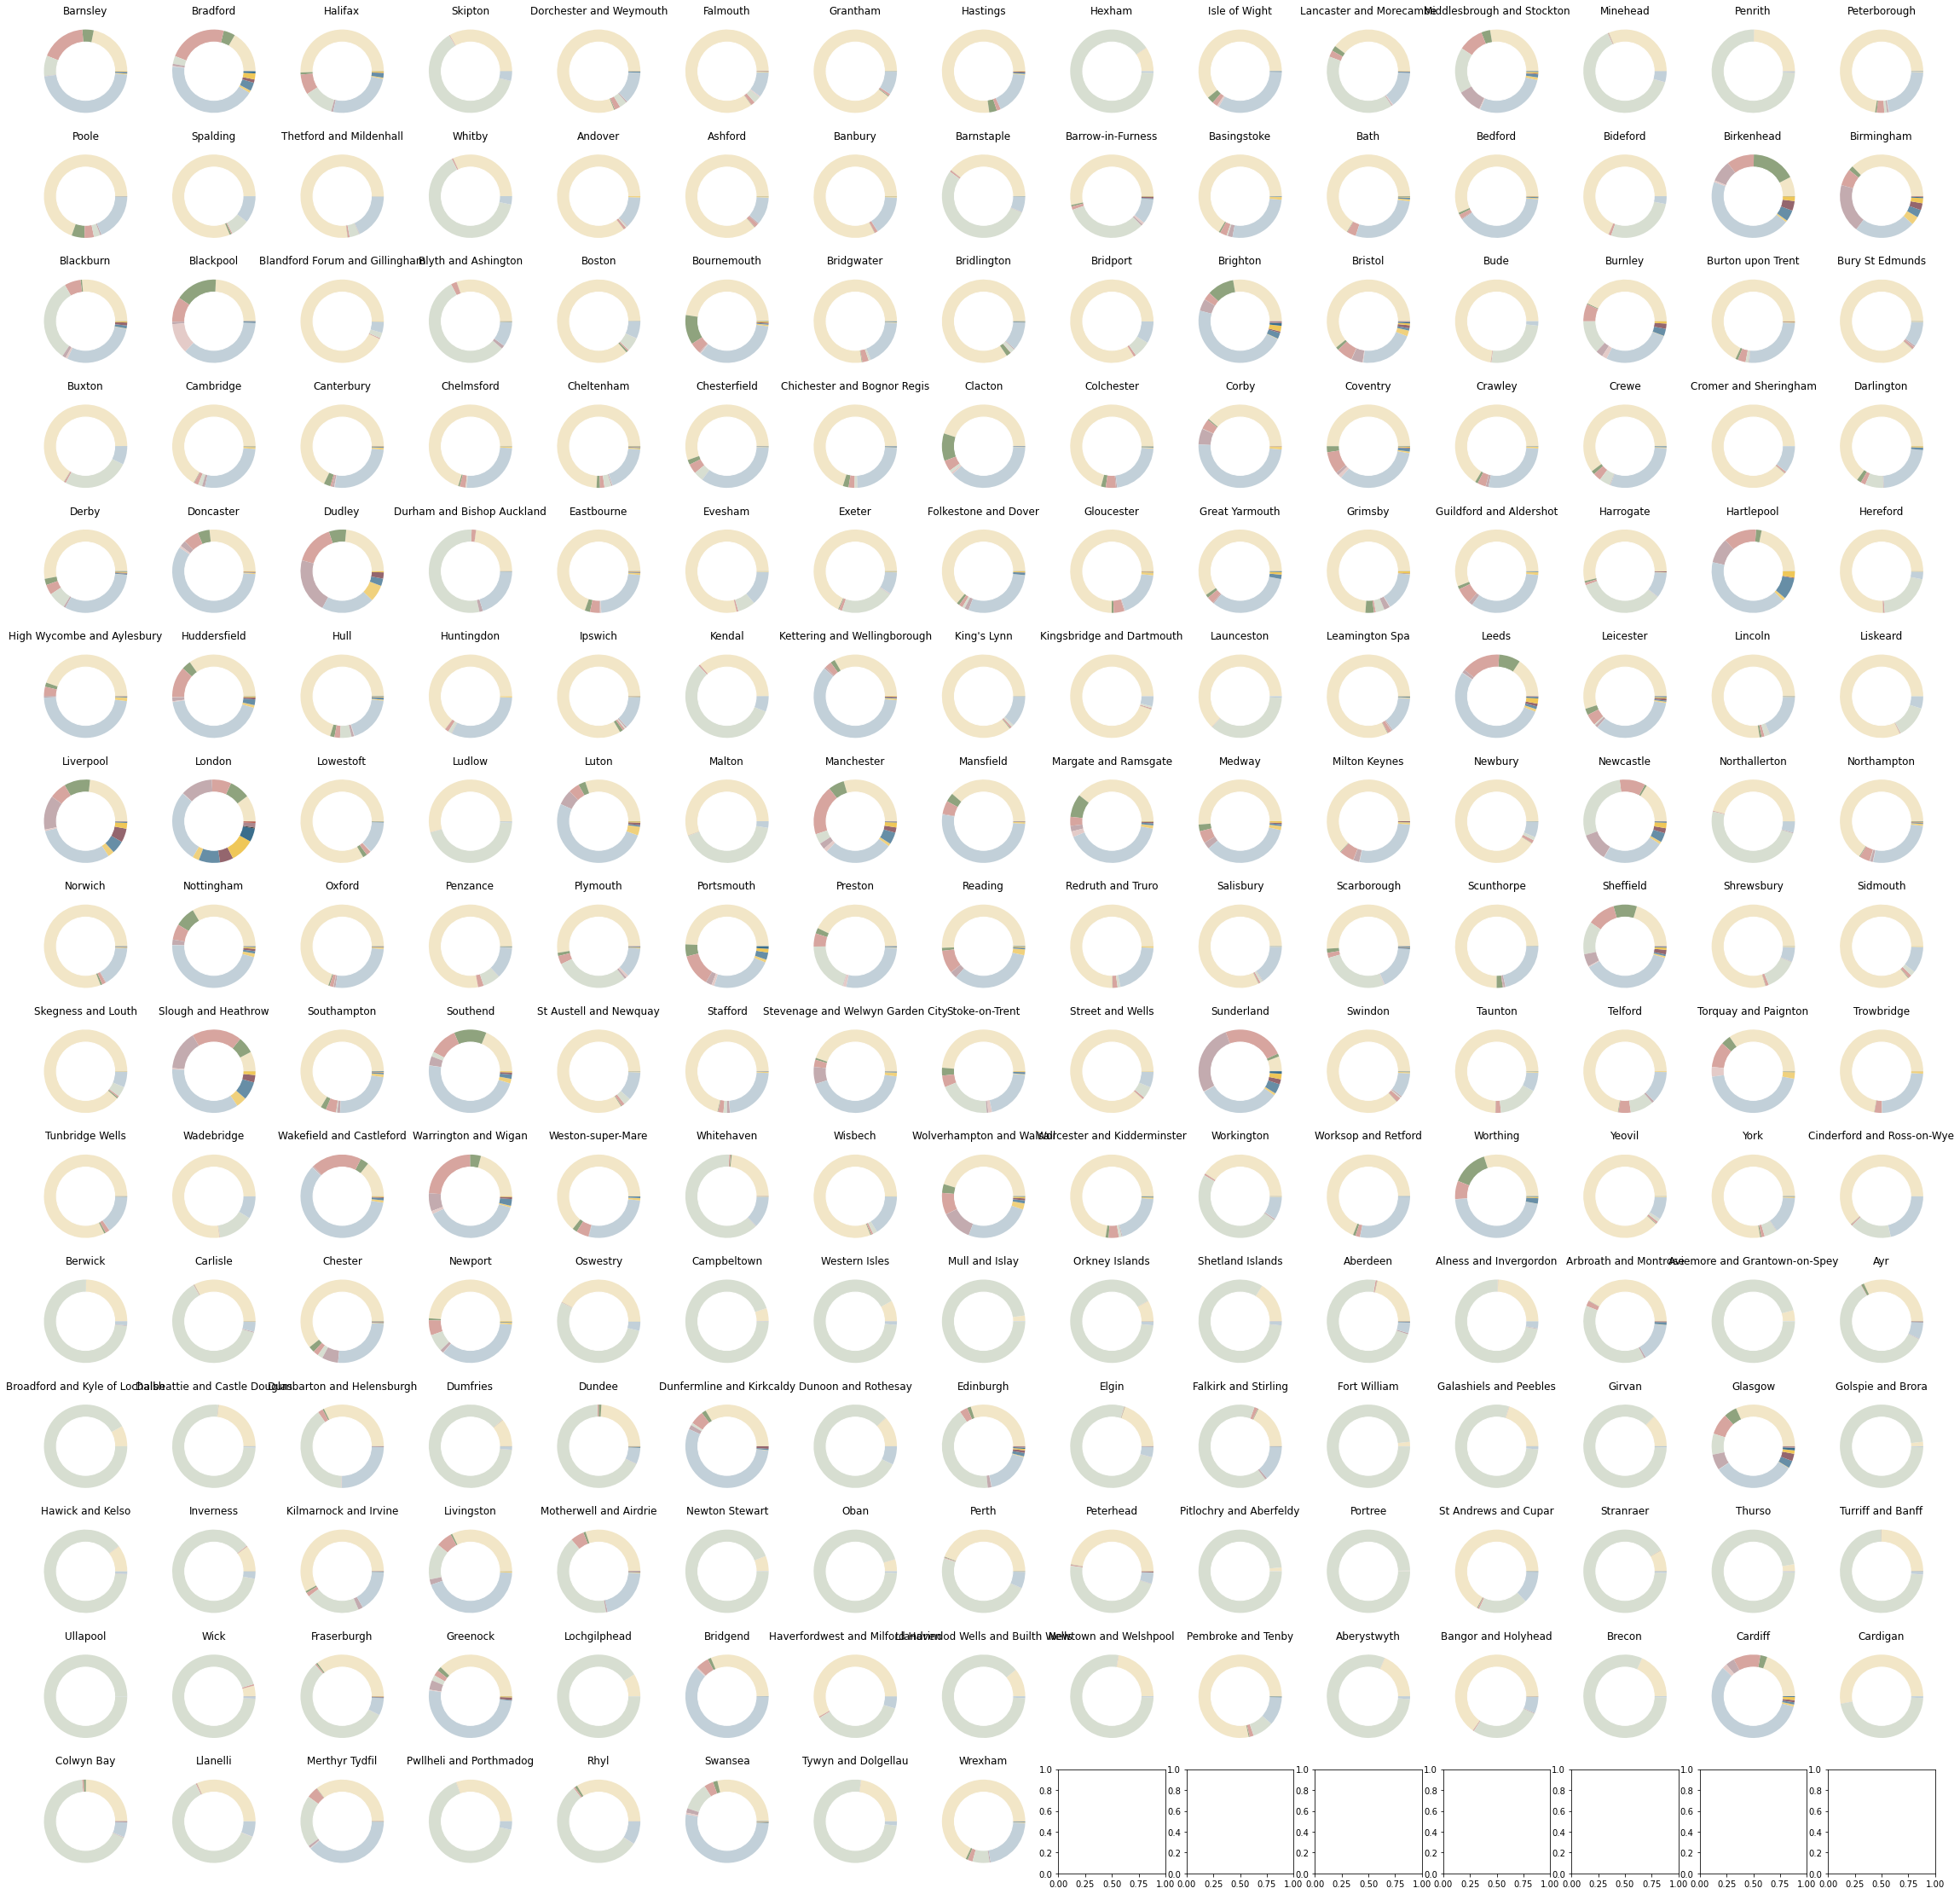

In [144]:
fig, axs = plt.subplots(15, 15, figsize=(40, 40))
axs = axs.flatten()
for i, place in enumerate(plot_data.columns):
    plot_data[place].plot.pie(colors=list(symbology.values()), labels=None, ax=axs[i], normalize=True)
    axs[i].axis("off")
    axs[i].add_artist(plt.Circle((0,0), .7, color="w"))
    axs[i].set_title(place)

In [38]:
interpolated = geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa_interpolated.pq")

In [39]:
interpolated = interpolated.set_index("TTWA11NM")

In [15]:
plot_data = geopandas.GeoDataFrame(columns=["level", "order", "area", "urbanity", "geometry"], crs=interpolated.crs)

In [16]:
centres = ['Distilled urbanity', 'Metropolitan urbanity', 'Regional urbanity', 'Local urbanity', 'Dense urban neighbourhoods']

In [41]:
mapdata = interpolated.set_geometry(interpolated.centroid)

centres = ['Hyper distilled urbanity', 'Distilled urbanity', 'Metropolitan urbanity', 'Regional urbanity', 'Local urbanity', 'Dense urban neighbourhoods']
sizes = pandas.DataFrame()
for centre in centres:
    sizes[centre] = interpolated[centre] * interpolated.area

In [42]:
centroids = interpolated.centroid
for level, c in enumerate(centres):
    sub = interpolated[interpolated[c] > 0]
    area = sub.area
    sub["sorter"] = sub[c] * area
    sub = sub.sort_values("sorter", ascending=False)
    for i, ix in enumerate(sub.index):
        plot_data.loc[ix] = [level, i, sub["sorter"].loc[ix], c, centroids.loc[ix]]
    interpolated = interpolated.drop(sub.index)

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [34]:
plot_data

,level,order,area,urbanity,geometry
London,0,0,7.883216e+06,Distilled urbanity,POINT (538859.548 181287.313)
Birmingham,1,0,1.075148e+06,Metropolitan urbanity,POINT (411486.764 285105.634)
Edinburgh,1,1,6.384964e+05,Metropolitan urbanity,POINT (336480.582 665538.228)
Glasgow,1,2,6.059172e+05,Metropolitan urbanity,POINT (254427.143 665611.252)
Manchester,1,3,5.153730e+05,Metropolitan urbanity,POINT (386884.766 394820.807)
...,...,...,...,...,...
Clacton,4,42,1.356900e+03,Dense urban neighbourhoods,POINT (616999.223 223054.267)
Yeovil,4,43,1.311523e+03,Dense urban neighbourhoods,POINT (353541.196 119693.402)
Kendal,4,44,8.299633e+02,Dense urban neighbourhoods,POINT (352816.440 492003.682)
Worksop and Retford,4,45,6.096959e+02,Dense urban neighbourhoods,POINT (468458.241 381521.949)


In [43]:
sizes = sizes.cumsum(axis=1)

In [44]:
sizes

,Hyper distilled urbanity,Distilled urbanity,Metropolitan urbanity,Regional urbanity,Local urbanity,Dense urban neighbourhoods
TTWA11NM,,,,,,
Barnsley,0.0,0.0,0.000000,0.000000,2.652940e+03,7.457278e+05
Bradford,0.0,0.0,0.000000,79723.179688,2.965356e+06,1.108895e+07
Halifax,0.0,0.0,0.000000,0.000000,2.213591e+05,2.167267e+06
Skipton,0.0,0.0,0.000000,0.000000,0.000000e+00,2.157967e+05
Dorchester and Weymouth,0.0,0.0,28749.791016,81876.955078,2.495261e+05,8.396391e+05
...,...,...,...,...,...,...
Pwllheli and Porthmadog,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00
Rhyl,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00
Swansea,0.0,0.0,0.000000,111034.203125,1.112047e+06,2.400959e+06


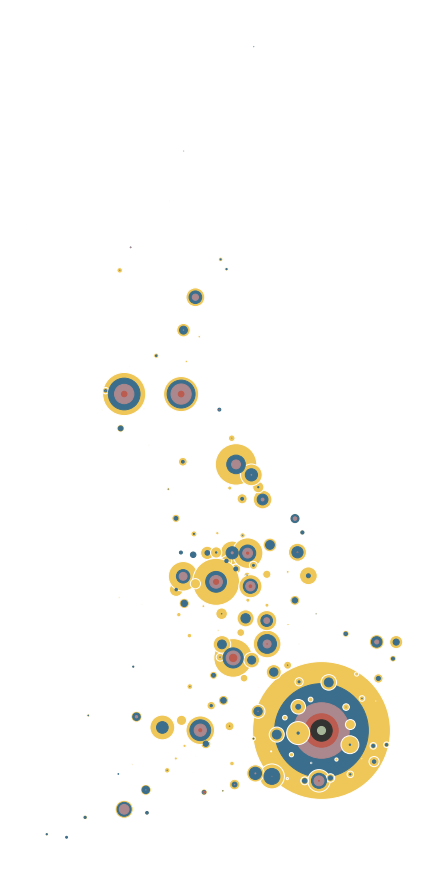

In [46]:
fig, ax = plt.subplots(figsize=(16, 16))
scaler = 20000

for i, centre in enumerate(centres[::-1]):
    if centre == 'Dense urban neighbourhoods':
        mapdata.drop("London").plot(markersize=sizes[centre].drop("London") / scaler, ax=ax, zorder=i+10, color=symbology[centre], edgecolor="w")
        mapdata.loc[["London"]].plot(markersize=sizes[centre].loc[["London"]] / scaler, ax=ax, zorder=i, color=symbology[centre], edgecolor="w")
    else:
        mapdata.drop("London").plot(markersize=sizes[centre].drop("London") / scaler, ax=ax, zorder=i+10, color=symbology[centre])
        mapdata.loc[["London"]].plot(markersize=sizes[centre].loc[["London"]] / scaler, ax=ax, zorder=i, color=symbology[centre])

ax.set_axis_off()
plt.savefig("figs/hierarchy_map.pdf")

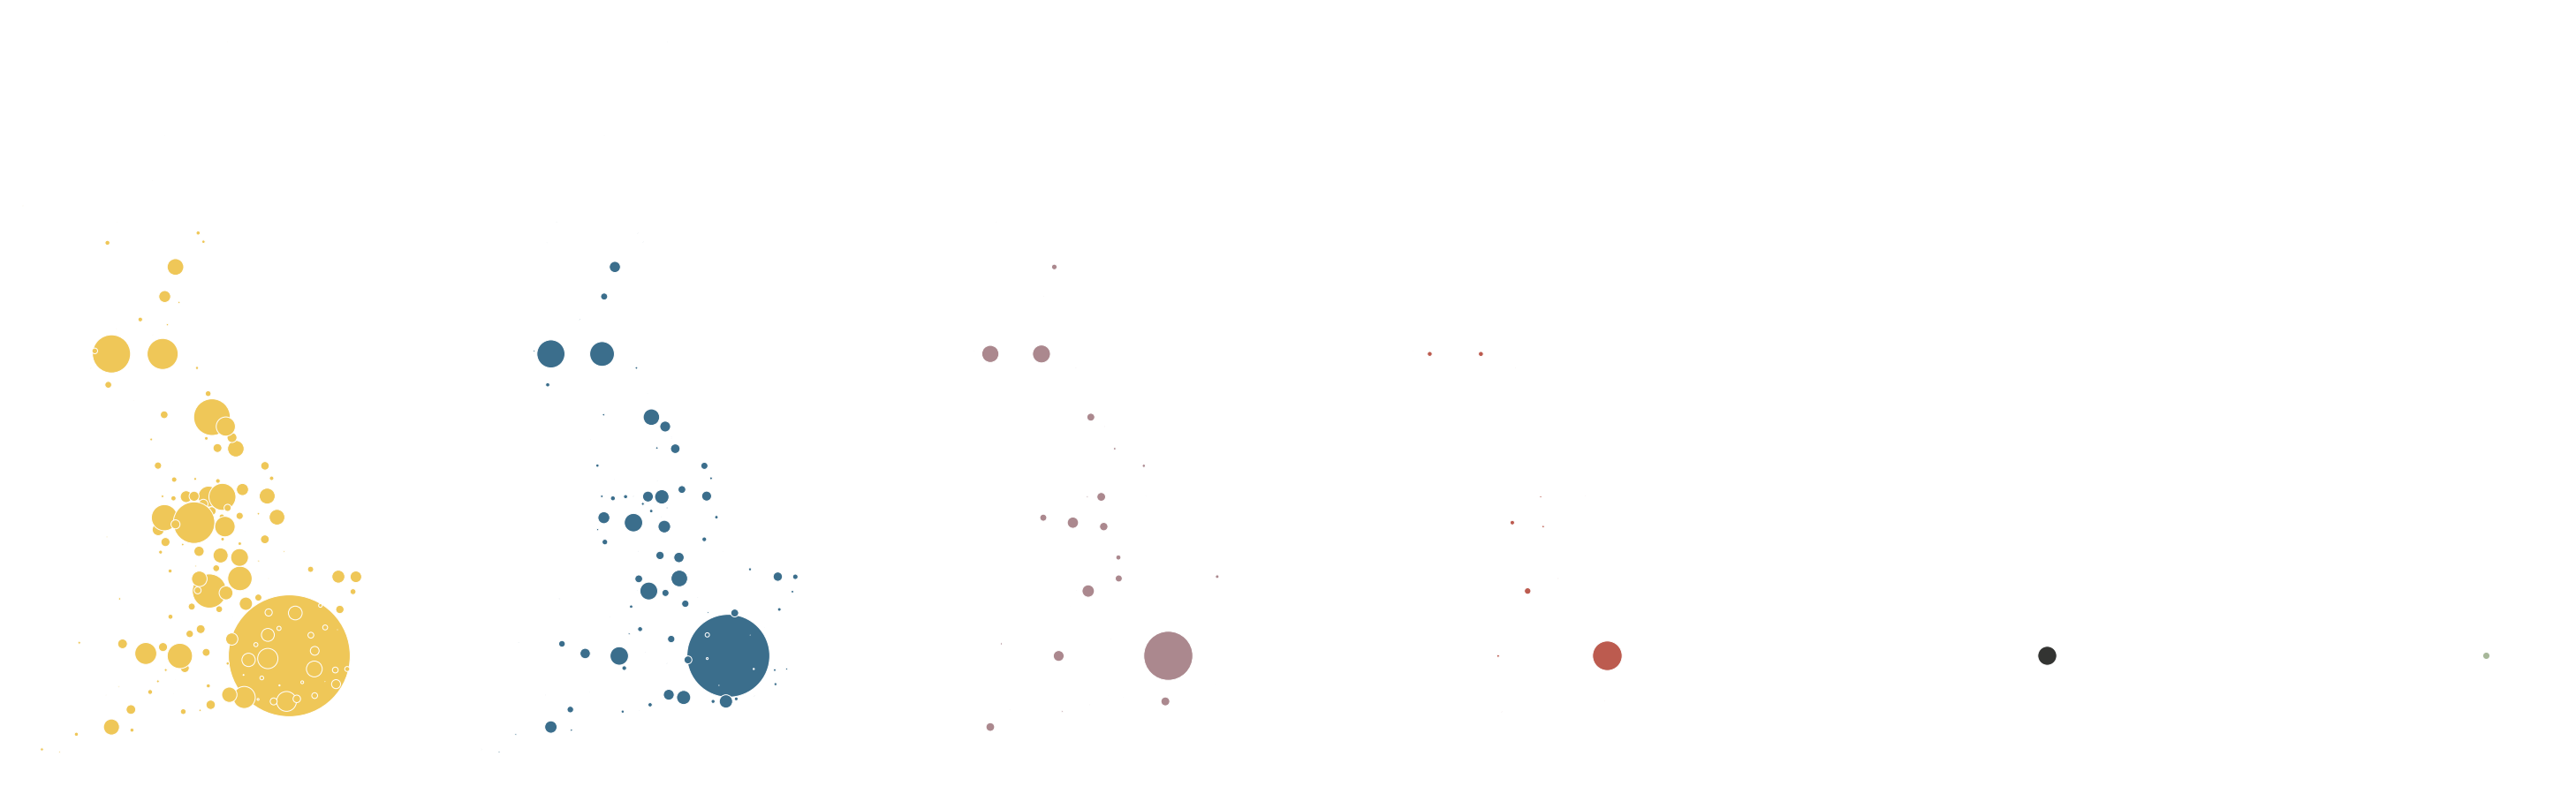

In [47]:
fig, axs = plt.subplots(1, 6, figsize=(52, 25))
scaler = 20000
axs = axs.flatten()

for i, centre in enumerate(centres[::-1]):
    mapdata.drop("London").plot(markersize=sizes[centre].drop("London") / scaler, ax=axs[i], zorder=i+10, color=symbology[centre], edgecolor="w")
    mapdata.loc[["London"]].plot(markersize=sizes[centre].loc[["London"]] / scaler, ax=axs[i], zorder=i, color=symbology[centre], edgecolor="w")

    axs[i].set_axis_off()
plt.savefig("figs/hierarchy_map_layers.pdf")

In [188]:
plot_data

,level,order,area,urbanity,geometry
London,0,0,7.883216e+06,Distilled urbanity,POINT (538859.548 181287.313)
Birmingham,1,0,1.075148e+06,Metropolitan urbanity,POINT (411486.764 285105.634)
Edinburgh,1,1,6.384964e+05,Metropolitan urbanity,POINT (336480.582 665538.228)
Glasgow,1,2,6.059172e+05,Metropolitan urbanity,POINT (254427.143 665611.252)
Manchester,1,3,5.153730e+05,Metropolitan urbanity,POINT (386884.766 394820.807)
...,...,...,...,...,...
Clacton,4,42,1.356900e+03,Dense urban neighbourhoods,POINT (616999.223 223054.267)
Yeovil,4,43,1.311523e+03,Dense urban neighbourhoods,POINT (353541.196 119693.402)
Kendal,4,44,8.299633e+02,Dense urban neighbourhoods,POINT (352816.440 492003.682)
Worksop and Retford,4,45,6.096959e+02,Dense urban neighbourhoods,POINT (468458.241 381521.949)


In [48]:
mapdata[["level", "order"]] = plot_data[["level", "order"]]

In [49]:
mapdata.order.max()

68

In [50]:
mapdata.loc[mapdata.level == 1, "order"] = mapdata.loc[mapdata.level == 1, "order"] * 5

In [51]:
mapdata.loc[mapdata.level == 2, "order"] = mapdata.loc[mapdata.level == 2, "order"] * 2.5
mapdata.loc[mapdata.level == 4, "order"] = mapdata.loc[mapdata.level == 4, "order"] * 1.5

In [52]:
for l in mapdata.level.dropna().unique():
    mapdata.loc[mapdata.level == l, "x"] = (mapdata.loc[mapdata.level == l, "order"] - mapdata.loc[mapdata.level == l, "order"].mean()) / mapdata.loc[mapdata.level == l, "order"].std()

In [53]:
mapdata.loc["London", 'x'] = 0 

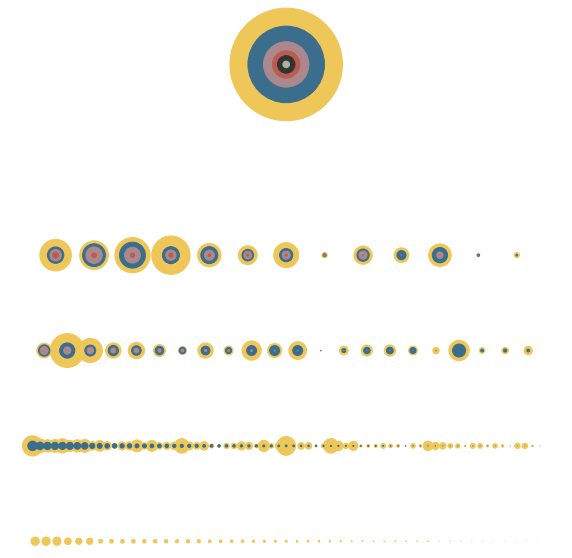

In [65]:
fig, ax = plt.subplots(figsize=(10, 10))
scaler = 30000

for i, centre in enumerate(centres[::-1]):
    ax.scatter(mapdata.x * 10, 1 - mapdata.level * 10, s=sizes[centre] / scaler, zorder=i+10, color=symbology[centre])

ax.set_axis_off()
# ax.axis('equal')
ax.set_ylim(-50, 7)
plt.savefig("figs/hierarchy_diagram.pdf")

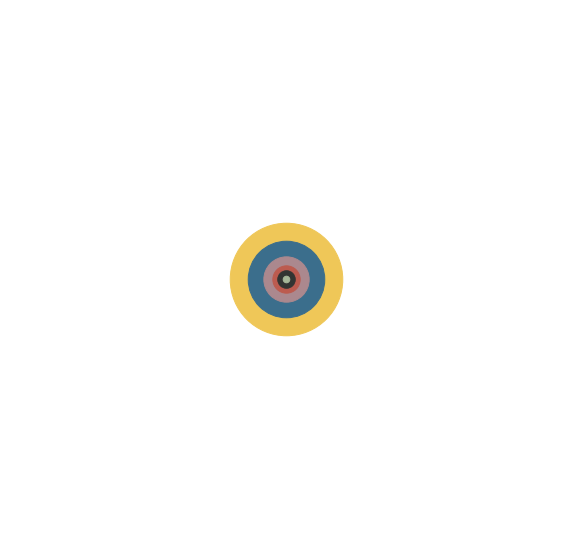

In [61]:
fig, ax = plt.subplots(figsize=(10, 10))
scaler = 30000

for i, centre in enumerate(centres[::-1]):
    ax.scatter(mapdata.loc[["London"]].x * 10, 1 - mapdata.loc[["London"]].level * 10, s=sizes.loc[["London"]][centre] / scaler, zorder=i+10, color=symbology[centre])

ax.set_axis_off()
# ax.axis('equal')
# ax.set_ylim(-42, 7)
plt.savefig("figs/hierarchy_london.pdf")